In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
train =  pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# DATA EXPLORATION

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train = train.iloc[:,0]

In [5]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 
X_train = X_train / 255.0
test = test / 255.0

Text(0, 0.5, 'Number of image samples')

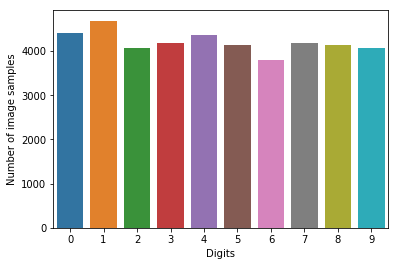

In [6]:
sns.barplot(x = y_train.unique(), y=y_train.value_counts())
plt.xlabel('Digits')
plt.ylabel('Number of image samples')

Looking at this class distribution graph, I can see that the classes are almost evenly distributed. Therefore, it does not require any resampling to be applied

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## We are reshaping the data into images.

* -1 is given so that the number of rows are dynamically written as per the dataset
* 28*28 is the size of the image
* 1 is channel as Images are in Black and White (Note - If it is in RGB, then channel value should be 3)

In [8]:
Y_train = tf.keras.utils.to_categorical(Y_train, 10)

# Splitting into Train and Validation Datasets

I split the dataset into train and validation datasets, and then while training, we can check accuracy by the validation dataset, which the neural network didn't see. I have chosen a 20%/80% split because it is the most common way to split the dataset.

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

In [10]:
batch_size = 128
num_classes = 10
epochs = 50

# Model Building

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu, padding="SAME"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu, padding="SAME"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu, padding="SAME"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         7

* The Input Layer is defined to read the images into the CNN
* Convolution Layer - These are important when nearby associations among the features matter. Here it is less likely that the pixels in opposite corner of the images will contribute to the classification. Therefore, I used the convolutional layer
* Max Pooling Layer - It selects the maximum element from the region of the feature map covered by the filter. So, the output would be a feature map containing the most prominent features of the previous feature map.
* Batch Normalization - It is technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.
* Dropout - It is a way of cutting too much association among features by dropping a specific percentage of weights randomly.
* Flatten - It is used when we get multidimensional output and want to make it linear to pass it onto a Dense layer. It is equivalent to numpy.ravel (Look at the shape before and flatten in the model summary)
* Dense - are used when association can exist among any feature to any other feature in data point

**The output layer in a classification problem should always be a softmax layer with the number of output classes as its paramter**


# Image Augmentation
To improve model's probability power, I will use Image Augmentations.

In [12]:
image_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

image_data_gen.fit(X_train)


# Training Convolutional Neural Network

In [13]:
h = model.fit_generator(image_data_gen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size)

Train for 262 steps, validate on 8400 samples
Epoch 1/50
262/262 - 12s - loss: 0.4621 - accuracy: 0.8558 - val_loss: 0.8488 - val_accuracy: 0.9820
Epoch 2/50
262/262 - 9s - loss: 0.1084 - accuracy: 0.9671 - val_loss: 0.0671 - val_accuracy: 0.9819
Epoch 3/50
262/262 - 9s - loss: 0.0826 - accuracy: 0.9755 - val_loss: 0.0354 - val_accuracy: 0.9892
Epoch 4/50
262/262 - 10s - loss: 0.0709 - accuracy: 0.9777 - val_loss: 0.0248 - val_accuracy: 0.9925
Epoch 5/50
262/262 - 9s - loss: 0.0580 - accuracy: 0.9818 - val_loss: 0.0324 - val_accuracy: 0.9896
Epoch 6/50
262/262 - 9s - loss: 0.0589 - accuracy: 0.9808 - val_loss: 0.0288 - val_accuracy: 0.9902
Epoch 7/50
262/262 - 9s - loss: 0.0509 - accuracy: 0.9840 - val_loss: 0.0221 - val_accuracy: 0.9935
Epoch 8/50
262/262 - 8s - loss: 0.0486 - accuracy: 0.9841 - val_loss: 0.0255 - val_accuracy: 0.9911
Epoch 9/50
262/262 - 9s - loss: 0.0462 - accuracy: 0.9856 - val_loss: 0.0266 - val_accuracy: 0.9912
Epoch 10/50
262/262 - 9s - loss: 0.0460 - accuracy: 

In [14]:
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)

# Plotting results

In [15]:
train_accuracies = h.history["accuracy"]
validation_accuracies = h.history["val_accuracy"]

epochs_range = list(range(1, epochs+1))

scatter_accuracy_hovertemplate = "Epoch: %{x}<br>Accuracy: %{y}"

data = [
    go.Scatter(x=epochs_range, y=train_accuracies, name="Train Accuracy", hovertemplate=scatter_accuracy_hovertemplate),
    go.Scatter(x=epochs_range, y=validation_accuracies, name="Validation Accuracy", hovertemplate=scatter_accuracy_hovertemplate)
]

title = go.layout.Title(text="Train & Validation Accuracies",
                        font=dict(size=25))

layout = go.Layout(template="plotly_dark",
                    xaxis=dict(ticks="outside", ticklen=5, tickvals=list(range(0, epochs+1, 2)), tickfont=dict(size=10), title=dict(text="Epochs", font=dict(size=17))),
                    yaxis=dict(title=dict(text="Accuracy", font=dict(size=14))),
                    title=title)

figure = go.Figure(data=data, layout=layout)
figure.show()

In [16]:
train_losses = h.history["loss"]
validation_losses = h.history["val_loss"]

scatter_loss_hovertemplate = "Epoch: %{x}<br>Loss: %{y}"

data = [
    go.Scatter(x=epochs_range, y=train_losses, name="Train Loss", hovertemplate=scatter_loss_hovertemplate),
    go.Scatter(x=epochs_range, y=validation_losses, name="Validation Loss", hovertemplate=scatter_loss_hovertemplate)
]

title = go.layout.Title(text="Train & Validation Losses",
                        font=dict(size=25))

layout = go.Layout(template="plotly_dark",
                    xaxis=dict(ticks="outside", ticklen=5, tickvals=list(range(0, epochs+1, 2)), tickfont=dict(size=10), title=dict(text="Epochs", font=dict(size=17))),
                    yaxis=dict(title=dict(text="Loss", font=dict(size=14))),
                    title=title)

figure = go.Figure(data=data, layout=layout)
figure.show()

In [17]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

In [18]:
confusion_mtx

array([[798,   0,   0,   0,   0,   0,   3,   0,   1,   0],
       [  0, 959,   0,   0,   1,   0,   1,   4,   1,   0],
       [  0,   0, 828,   1,   0,   0,   0,   1,   1,   0],
       [  0,   0,   3, 840,   0,   0,   0,   0,   2,   0],
       [  0,   0,   0,   0, 847,   0,   1,   0,   0,   1],
       [  0,   0,   0,   7,   0, 727,   1,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0, 884,   0,   0,   0],
       [  1,   1,   7,   0,   0,   0,   0, 876,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0, 784,   0],
       [  0,   0,   0,   0,   0,   0,   0,   3,   2, 812]])

In [19]:
results=model.predict(test)

In [20]:
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("result.csv",index=False)